https://www.kaggle.com/alixmartin/covid-19-predictions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing datasets
full_table = pd.read_csv('./DataSources/covid_19_clean_complete.csv', 
                         parse_dates=['Date'])
full_table.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Thailand,15.0000,101.0000,2020-01-22,2,0,0
1,NaN,Japan,36.0000,138.0000,2020-01-22,2,0,0
2,NaN,Singapore,1.2833,103.8333,2020-01-22,0,0,0
3,NaN,Nepal,28.1667,84.2500,2020-01-22,0,0,0
4,NaN,Malaysia,2.5000,112.5000,2020-01-22,0,0,0


In [3]:
def get_time_series(country, province=None):
    if province:
        df = full_table[(full_table['Country/Region'] == country) 
                        & (full_table['Province/State'] == province)
                        & (full_table['Confirmed'] > 0)]
    else:
        df = full_table[(full_table['Country/Region'] == country) 
                        & (full_table['Confirmed'] > 0)]
    return df.set_index('Date')[['Confirmed']]

In [4]:
country = 'Romania'
df = get_time_series(country)
df.columns = [df.columns[0] + ' ' + country]
df.tail()

,Confirmed Romania
Date,
2020-03-14,123
2020-03-15,131
2020-03-16,158
2020-03-17,184
2020-03-18,260


Background:

I will use a model from a marketing paper by Emmanuelle Le Nagard and Alexandre Steyer, that attempts to reflect the social structure of a diffusion process. Their application was the diffusion of innovations, not epidemics. However, there are commonalities in both domains, as the number of contacts each infected/adopter has seems relevant. It also has the added benefit to allow fitting parameters to the beginning of a time series.

paper is available (in French):
https://www.jstor.org/stable/40588987

The model is also sensitive to when we define the origin of time for the epidemic process. Here, I just took the first point of the time series available, but adding a lag parameter could be attempted.

In [5]:
import math
def model(N, a, alpha, t):
    # we enforce N, a and alpha to be positive numbers using min and max functions
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * t)) ** max(alpha, 0)

In [6]:
def model_loss(params):
    N, a, alpha = params
    model_x = []
    r = 0
    for t in range(len(df)):
        r += (model(N, a, alpha, t) - df.iloc[t, 0]) ** 2
#         print(model(N, a, alpha, t), df.iloc[t, 0])
    return r 

We need to explore the 3d parameter space to find a minimum, using gradient descent. There are a number of algorithms to do that in scipy.optimize, I stopped at the first one that seemed to work. Generalized Reduced Gradient as in Excel solver also works.

In [7]:
import numpy as np
from scipy.optimize import minimize
opt = minimize(model_loss, x0=np.array([200000, 0.1, 15]), method='Nelder-Mead', tol=1e-5).x
opt

array([2.89713965e+05, 1.21217305e-02, 4.72945047e+00])

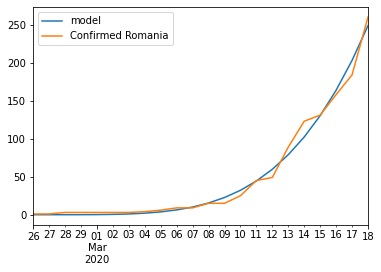

In [8]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

model_x = []
for t in range(len(df)):
    model_x.append([df.index[t], model(*opt, t)])
model_sim = pd.DataFrame(model_x, dtype=int)
model_sim.set_index(0, inplace=True)
model_sim.columns = ['model']
pd.concat([model_sim, df], axis=1).plot()
plt.show()

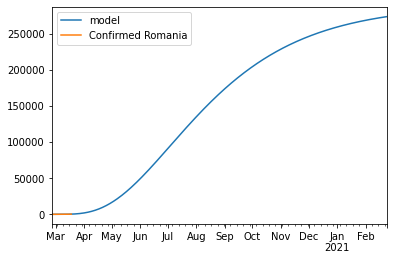

In [9]:
import datetime
start_date = df.index[0]
n_days = 365
extended_model_x = []
for t in range(n_days):
    extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt, t)])
extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
extended_model_sim.set_index(0, inplace=True)
extended_model_sim.columns = ['model']
pd.concat([extended_model_sim, df], axis=1).plot()
plt.show()

In [10]:
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, extended_model_sim], axis=1)
concat_df[concat_df.index.day % 30 == 0].astype({'model': 'int32'})

,Confirmed Romania,model
2020-03-30,nan,1523
2020-04-30,nan,15669
2020-05-30,nan,46755
2020-06-30,nan,89591
2020-07-30,nan,132273
2020-08-30,nan,171523
2020-09-30,nan,203414
2020-10-30,nan,227213
2020-11-30,nan,245515
2020-12-30,nan,258383


In [11]:
def display_fit(df, opt, ax):
    model_x = []
    for t in range(len(df)):
        model_x.append([df.index[t], model(*opt, t)])
    model_sim = pd.DataFrame(model_x, dtype=int)
    model_sim.set_index(0, inplace=True)
    model_sim.columns = ['model']
    return pd.concat([model_sim, df], axis=1).plot(ax=ax, figsize=(5, 4))

def display_extended_curve(df, opt, ax):
    start_date = df.index[0]
    n_days = 180
    extended_model_x = []
    for t in range(n_days):
        extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt, t)])
    extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
    extended_model_sim.set_index(0, inplace=True)
    extended_model_sim.columns = ['model']
    return pd.concat([extended_model_sim, df], axis=1).plot(ax=ax, figsize=(12, 8))

In [12]:
full_table[full_table['Country/Region'] == 'China']

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
154,Hubei,China,31,112,2020-01-22,444,17,28
158,Guangdong,China,23,113,2020-01-22,26,0,0
159,Henan,China,34,114,2020-01-22,5,0,0
160,Zhejiang,China,29,120,2020-01-22,10,0,0
161,Hunan,China,28,112,2020-01-22,4,0,0
...,...,...,...,...,...,...,...,...
15364,Inner Mongolia,China,44,114,2020-03-18,75,1,73
15365,Ningxia,China,37,106,2020-03-18,75,0,75
15369,Qinghai,China,36,96,2020-03-18,18,0,18
15370,Macau,China,22,114,2020-03-18,15,0,10


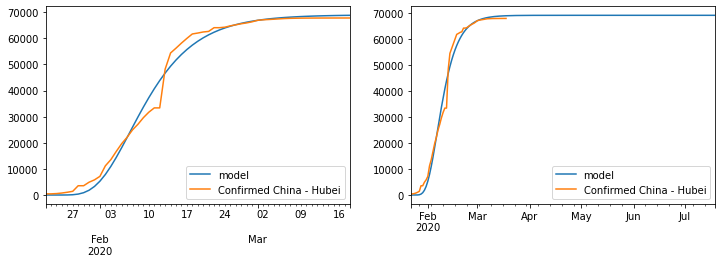

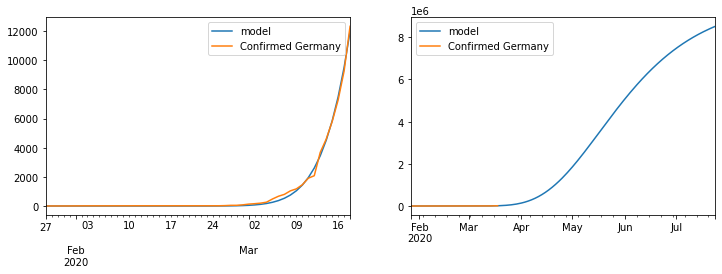

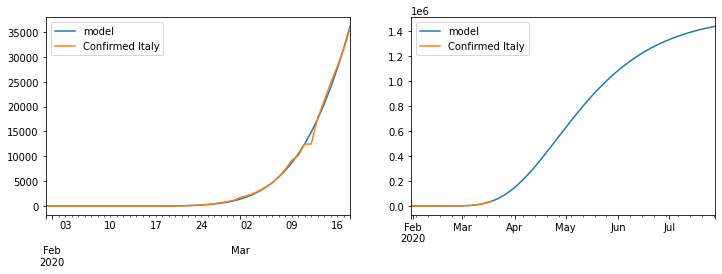

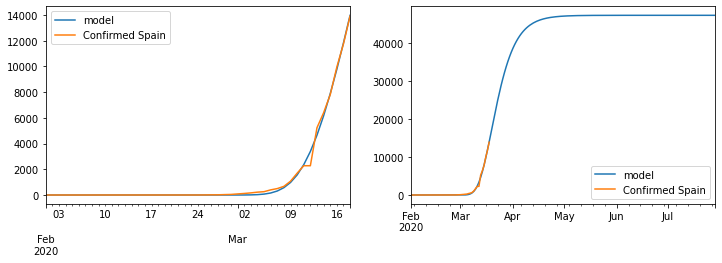

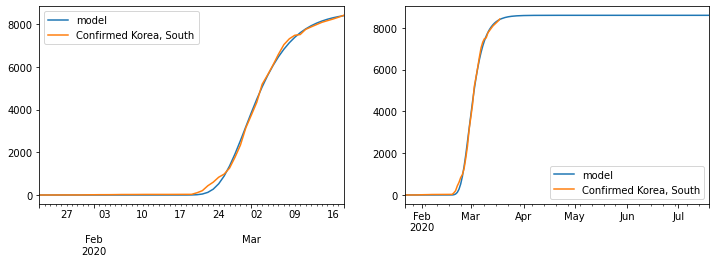

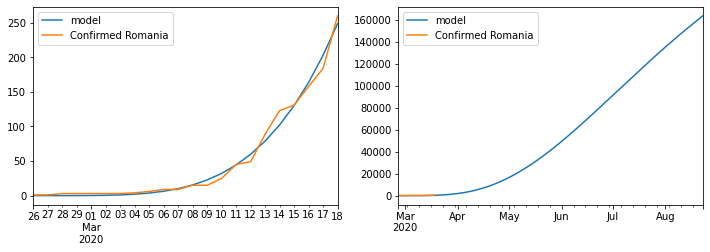

In [13]:
stats = []
country_list = ['China', 'Germany', 'Italy', 'Spain', 'Korea, South', 'Romania']
for country in country_list:
    if country=='China':
        df = get_time_series(country, province='Hubei')
        country = 'China - Hubei'
    else:
        df = get_time_series(country)
#    if len(df) == 0 or max(df['Confirmed']) < 1000: # only consider countries with at least 1000 cases
#        continue
    df.columns = [df.columns[0] + ' ' + country]
    opt = minimize(model_loss, x0=np.array([200000, 0.1, 15]), method='Nelder-Mead', tol=1e-5).x
#     print(country, opt)
    if min(opt) > 0:
        stats.append([country, *opt])
        n_plot = len(stats)
        plt.figure(1)
        ax1 = plt.subplot(221)
        display_fit(df, opt, ax1)
        ax2 = plt.subplot(222)
        display_extended_curve(df, opt, ax2)
        plt.show()
stats_df = pd.DataFrame(stats)
stats_df.columns = ['country', 'N', 'a', 'alpha']

In [14]:
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:20,.4f}'.format
stats_df.astype({'N': 'int'}).sort_values(by='N', ascending=False)

,country,N,a,alpha
1,Germany,9731515,0.0297,26.9902
2,Italy,1523861,0.0304,13.6235
5,Romania,289713,0.0121,4.7295
0,China - Hubei,68996,0.1482,9.9528
3,Spain,47308,0.1283,444.8840
4,"Korea, South",8593,0.2081,"2,680.7712"


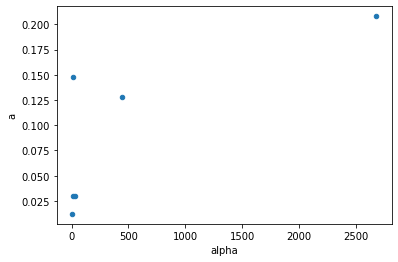

In [15]:
ax = stats_df.plot.scatter(x='alpha', y='a')
# ax.set_xlim([0, 100])
plt.show()